# Assignment 3

Due Mon, Mar  22, 9:30am, commited to your `phys248` repo on the Abacus GitLab server. 

## 1.
The _SIR_ model (W. O. Kermack and A. G. McKendrick, 1927, see [Wikipedia page on this topic for references and additional detail](https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease)) describes the outbreak and evolution of an infectious desease.

The model describes the evolution of a population with $N$ individuals, each of which belongs at any given time to one of three _compartments_:
* $S(t)$ is used to represent the number of individuals not yet infected with the disease at time t, and which are susceptible to the disease.
* $I(t)$ is the number of individuals that are infected and contagious.
* $R(t)$ represents individuals who have been infected and then removed from the disease, either due to immunization or due to death. Individuals in this category are not able to be infected again or to transmit the infection to others.

The total population $ N = S(t) + I(t) +R(t) $ is constant. In this model there is a general progression of individuals: 
$$\mathcal{S} \rightarrow \mathcal{I}  \rightarrow \mathcal{R}$$

The differential equations are interestingly quite similar to reaction networks in chemistry or nuclear physics, where a member of compartment $\mathcal{S}$ has to interact with a member of compartment $\mathcal{I}$ to create a new member of $\mathcal{I}$. This is equivalent to a reaction. The transition from $\mathcal{I}$ to $\mathcal{R}$ is equivalent to a radioactive decay.

The system of differential equations is:
$$ \frac{dS}{dt} = -\frac{\beta S I}{N} $$
$$ \frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I$$
$$ \frac{dR}{dt} = \gamma I$$


$\gamma$ represents the mean recovery/death rate in units of $\mathrm{d^{-1}}$, and $1/\gamma$ is the mean infective period $P_\mathrm{inf} = 1/\gamma$. The infective period is the asymptomatic incubation period plus the symptomatic time until the individual transitions to compartment $\mathcal{R}$. 

$\beta$ represents the infection rate. If $n_\mathrm{inf}$ is the number of members of $\mathcal{S}$ each member of $\mathcal{I}$ infects, then $\beta = n_\mathrm{inf} / P_\mathrm{inf} = n_\mathrm{inf} \gamma$. 

The final input parameters are the population size $N$ and the initial values $S_0$, $I_0$ and $R_0$. 

### 1.1 
Solve the model equations for $\gamma = 1/10\mathrm{d^{-1}}$ which implies an infective period of $P_\mathrm{inf} = 1/\gamma = 10\mathrm{d}$. Use as initial values $(S_0, I_0, R_0) = (N-I_0, 574,0)$ and $N=1.1\times10^7$. These are the parameters that describe approximately the situation of the Corona virus infection in China, focussing on the city of Wuhan, on January 22 2020:

![Cvirus](../Figs/Cvirus.png)

This data could at the time be viewed and exlored at the WHO web page.

By Feb 4 (13 days later) the number of infected individuals had increased to $24.4\times10^3$ individuals.

The goal is to estimate $n_\mathrm{inf}$. Start with $n_\mathrm{inf} = 2$ implying that each infected person will infect on average 2 uninfected individuals. Make a simulation for the duration of $13\mathrm{d}$ and repeat while adjusting the $n_\mathrm{inf}$ parameter (to within one decimal) until it approximately matches  the Wuhan data, i.e. after 13 days the $\mathcal{I}$ compartment has risen from its initial value to approximately $25\mathrm{k}$. What is the best value of  $n_\mathrm{inf}$?

Save the plot for this part to the file `Fig1.1.png`.

Note: The parameter $n_\mathrm{inf}$ is now widely known as the reproductive number $R_0$, not to be confused with the variable $R$ we are using here for the removed population.

The system of differential equations is:
$$ \frac{dS}{dt} = -\frac{\beta S I}{N} $$
$$ \frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I$$
$$ \frac{dR}{dt} = \gamma I$$


In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from matplotlib import cm
from datetime import datetime
import pandas as pd

In [207]:
#want: n_inf, aka R0=reproductive number, initially n_inf=2
#simulate, adjusting n_inf until it matches Wuhan data
##system parameters/constants:
Ndays = 13 #simulate for 13 day period
gamma = 1/10 #d^-1, mean recovery/death rate
P_inf = 1/gamma #d, mean infective period
N = 1.1e7 #total population size
I0 = 574 #initial infected people
S0 = N-I0 #initial susceptible people
R0 = 0 #initial removed (recovered/dead) people
days = np.linspace(0,13,14)

##differential equation (coupled):
#y = [S,I,R]
def diff_eqs(y,t,beta,N,gamma):
    S,I,R = y
    dSdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dRdt = gamma*I
    return [dSdt, dIdt, dRdt]

##initial solution, n_inf=2
n_inf=2
beta = n_inf*gamma #infection rate, beta=n_inf/P_inf=n_inf*gamma
sols = integrate.odeint(diff_eqs, [S0,I0,R0], days, args=(beta,N,gamma))
S,I,R = sols[-1]
#print(sols)
print("Initial solution for n_inf=2, after 13 days: S = %.2f, I = %.2f, R=%.2f" %(sols[-1][0],sols[-1][1],sols[-1][2]))
print("Initial estimate of number of infected people, I, after 13 days: %.2f" %sols[-1][1])
print("n_inf = %.4f" %n_inf)

##estimate value of n_inf such that I=25000 after 13 days:
#bisection kinda deal, where we are looking for I_goal, rather than the root.
#note: this method doesn't give good estimate for upper limit of 5,
# since the first midpoint (n_inf=3.5) is lower than the good approximation of n_inf=3.9

n_inf = (2,10) #10 is large upper limit, but it gets cut down pretty quick 
count=0
I_goal = 25000
while(round(I) != I_goal): #round to nearest integer for extra good approx
    if count>=10000:
        print("max number of iterations exceeded, nearest I estimation = %.4f" %I)
        break 
    count+=1
    n_mid = (n_inf[0]+n_inf[1])/2 
    beta_up = n_inf[1]*gamma
    beta_low = n_inf[0]*gamma
    sol_up = integrate.odeint(diff_eqs, [S0,I0,R0], days, args=(beta_up,N,gamma))
    I_up = sol_up[-1][1]
    sol_low = integrate.odeint(diff_eqs, [S0,I0,R0], days, args=(beta_low,N,gamma))
    I_low = sol_low[-1][1]
    if(abs(I_up-I_goal)<abs(I_low-I_goal)):
        #then I_up is closer to I_goal
        sol = sol_up
        n_inf = (n_mid, n_inf[1])
        flag = 1
    else:
        sol = sol_low
        n_inf = (n_inf[0], n_mid)
        flag = 0
    #print(sol_up, sol_low, n_inf)
    S,I,R = sol[-1]
I_arr = sol[:,1]
n_inf = n_inf[flag]

print()
print("After determining better estimate of n_inf to match the known number of infected people:")
print("solution after 13 days: S = %.2f, I = %.2f, R = %.2f" %(S,I,R))
print("Estimate of number of infected people, I = %.2f"%I)
print("n_inf for this estimate: %.4f" %(n_inf))

Initial solution for n_inf=2, after 13 days: S = 10996362.84, I = 2105.29, R=1531.88
Initial estimate of number of infected people, I, after 13 days: 2105.29
n_inf = 2.0000

After determining better estimate of n_inf to match the known number of infected people:
solution after 13 days: S = 10966577.58, I = 24999.88, R = 8422.55
Estimate of number of infected people, I = 24999.88
n_inf for this estimate: 3.9061


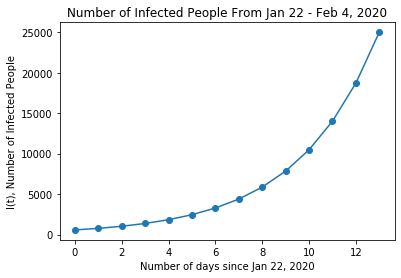

In [208]:
##plot:
plt.plot(days, I_arr, '-o')
plt.title('Number of Infected People From Jan 22 - Feb 4, 2020')
plt.xlabel("Number of days since Jan 22, 2020")
plt.ylabel('I(t), Number of Infected People')
plt.savefig('Fig1.1.png')
plt.show()

### 1.2 
Using these parameters make a simulation for $100d$, and plot the three compartments $S$, $I$ and $R$. We are also interested in the rate of hospital admissions per day. These are 5% of the rate of those who transition from $I$ to $R$, i.e. 5% of $\frac{dR}{dt}$. Add as well a line for the 1% fraction of those in $R$ who die. Finally, add a horizontal line for the capacity of hospital beds available in terms of admission capacity per day. China has on average [4.34 beds per 1000 people](https://en.wikipedia.org/wiki/List_of_OECD_countries_by_hospital_beds). Assume that each patient stays 4 days in hospital, and that 20% of the available hospital beds can be used for Corona virus patients. 

#### 1.2.1
After how many days from the beginning of the simulations on Jan 22nd does the hospital admission per day according to the simulation with the $n_\mathrm{inf}$ parameter from **1.1** exceed the available capacity? How many people would have died at this point? (Find these numbers approximately by interacting with your graph zooming in.) Further, in this scenario, by how much would the daily admission exceed capacity when it peaks, and what is the asymptotic number of people who would have died?

#### 1.2.2
Obviously this is not the scenario that unfolded, because $n_\mathrm{inf}$ was dramatically reduced through physical distancing. Esimate how large $n_\mathrm{inf}$ may at most be so that the hospital capacity is not overwhelmed. 

You can see that this scenario is also not what unfolded, at least not in most cases. Interpret your simulation output and speculate why this is also not what happened, and why in most places $n_\mathrm{inf}$ was further reduced and kept lower. 

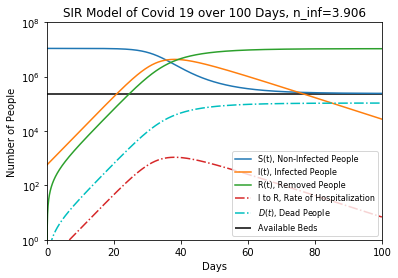

In [209]:
#1.2:
Ndays = 100 #simulate for 13 day period
days = np.linspace(0,Ndays, 2000)
beta = n_inf*gamma #new beta with better approx

sol2 = integrate.odeint(diff_eqs, [S0,I0,R0], days, args=(beta,N,gamma))
S,I,R = sol2.T

#hospitalized: 5% of dRdt
h_rate = .05*np.gradient(R)
#dead: 1% of R
dead = .01*R
#hospital beds: 4.34 beds/1000 people
Nbeds = N*4.34/1000
#beds available: 20% of total beds
covid_beds = .2*Nbeds
#open beds: 
open_beds = covid_beds*Ndays/4

#plot:
plt.plot(days,S,label="S(t), Non-Infected People")
plt.plot(days,I,label="I(t), Infected People")
plt.plot(days,R,label="R(t), Removed People")
plt.plot(days,h_rate,'-.',label="I to R, Rate of Hospitalization")
plt.plot(days,dead,'c-.',label="$D(t)$, Dead People")
plt.hlines(open_beds,0, max(days),label="Available Beds")
plt.legend()
#adjust axes for better readability
plt.ylim(1e0,1e8)
plt.xlim(0,Ndays)
plt.yscale('log')
plt.title("SIR Model of Covid 19 over %d Days, n_inf=%.3f" %(Ndays, n_inf))
plt.xlabel("Days")
plt.ylabel("Number of People")
plt.legend(fontsize=8, loc='best')

### 1.2.1
After how many days from the beginning of the simulations on Jan 22nd does the hospital admission per day according to the simulation with the  𝑛inf  parameter from 1.1 exceed the available capacity? How many people would have died at this point? (Find these numbers approximately by interacting with your graph zooming in.) Further, in this scenario, by how much would the daily admission exceed capacity when it peaks, and what is the asymptotic number of people who would have died?

In [176]:
#1.2.1:
#find day through iterating through I, rather than inspecting graph
count = 0
print("Point at which hospital admission per day exceeds available capacity:")
print("Count | Day  | Infected")
print("-----------------------")
while(I[count] <= open_beds):
    count +=1 
print("{:3}   | {:3.0f}  |  {:4.0f}".format(count,days[count],I[count]))

print("")
print("The hospital admission per day exceeds the available capacity after {:.0f} days.".format(days[count]))
print("At this point, {:.0f} people will have died.".format(dead[count]))


peak = max(I-I[count])
print("At this peak, the daily admission would exceed the capacity by {:.0f}.".format(peak))
print("The asymptotics number of people who would have died is {:.0f}.".format(dead[-1]))

Point at which hospital admission per day exceeds available capacity:
Count | Day  | Infected
-----------------------
418   |  21  |  240216

The hospital admission per day exceeds the available capacity after 21 days.
At this point, 841 people will have died.
At this peak, the daily admission would exceed the capacity by 4106752.
The asymptotics number of people who would have died is 107288.


### 1.2.2
Obviously this is not the scenario that unfolded, because  𝑛inf  was dramatically reduced through physical distancing. Esimate how large  𝑛inf  may at most be so that the hospital capacity is not overwhelmed.

You can see that this scenario is also not what unfolded, at least not in most cases. Interpret your simulation output and speculate why this is also not what happened, and why in most places  𝑛inf  was further reduced and kept lower.

In [189]:
print(open_beds)
print(round(open_beds, -3))

238700.0
239000.0


In [203]:
#1.2.2:

#use larger number of days for better estimate of n_inf
Ndays = 500
days = np.linspace(0,Ndays, 5000)
#clear S,I,R 
S,I,R = [0],[0],[0]

#do similar as for 1.1 except for new I_goal and different n_inf initial approx
#also considering max(I) for each n_inf
I_goal = open_beds
n_inf = (0,11) 
count=0
while(round(max(I)) != I_goal): 
    #should really add convergence test
    if count>=10000:
        print("max number of iterations exceeded, nearest max I estimation = %.4f" %max(I))
        break 
    count+=1
    n_mid = (n_inf[0]+n_inf[1])/2 
    beta_up = n_inf[1]*gamma
    beta_low = n_inf[0]*gamma
    sol_up = integrate.odeint(diff_eqs, [S0,I0,R0], days, args=(beta_up,N,gamma))
    I_up = sol_up[:,1]
    sol_low = integrate.odeint(diff_eqs, [S0,I0,R0], days, args=(beta_low,N,gamma))
    I_low = sol_low[:,1]
    if(abs(max(I_up)-I_goal)<abs(max(I_low)-I_goal)):
        #then I_up is closer to I_goal
        sol = sol_up
        n_inf = (n_mid, n_inf[1])
        flag = 1
    else:
        sol = sol_low
        n_inf = (n_inf[0], n_mid)
        flag = 0
    S,I,R = sol.T

print(n_inf, max(I))
n_inf = n_inf[flag]

print("For hospitals to not be overwhelmed, maximum number of infected people must equal number of available beds. \
This results in n_inf = {:.3f}".format(n_inf))

(1.251210778951645, 1.2512111067771912) 238700.33636305726
For hospitals to not be overwhelmed, maximum number of infected people must equal number of available beds. This results in n_inf = 1.251


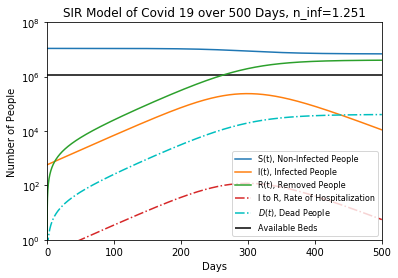

In [205]:
#plotting this scenario:

beta = n_inf*gamma #new beta with better approx

sol3 = integrate.odeint(diff_eqs, [S0,I0,R0], days, args=(beta,N,gamma))
S,I,R = sol3.T

#hospitalized: 5% of dRdt
h_rate = .05*np.gradient(R)
#dead: 1% of R
dead = .01*R
#hospital beds: 4.34 beds/1000 people
Nbeds = N*4.34/1000
#beds available: 20% of total beds
covid_beds = .2*Nbeds
#open beds: 
open_beds = covid_beds*Ndays/4

#plot:
plt.plot(days,S,label="S(t), Non-Infected People")
plt.plot(days,I,label="I(t), Infected People")
plt.plot(days,R,label="R(t), Removed People")
plt.plot(days,h_rate,'-.',label="I to R, Rate of Hospitalization")
plt.plot(days,dead,'c-.',label="$D(t)$, Dead People")
plt.hlines(open_beds,0, max(days),label="Available Beds")
plt.legend()
#adjust axes for better readability
plt.ylim(1e0,1e8)
plt.xlim(0,Ndays)
plt.yscale('log')
plt.title("SIR Model of Covid 19 over %d Days, n_inf=%.3f" %(Ndays, n_inf))
plt.xlabel("Days")
plt.ylabel("Number of People")
plt.legend(fontsize=8, loc='best')

The two SIR model plots above clearly are not the same, meaning the hospitals were in fact overloaded. In the plot directly above, we can see that the number of infected people never crosses the number of available beds. In reality, n_inf was higher, causing hospital overloads.

## Problem 2

$$
f(x) = \sin(x^{0.9})
$$ and
$$
g(x) = \cos(2x+\sqrt{x})
$$

1. Plot $g(x)$ vs. $f(x)$ for $x \in [0, \dots ,50]$ using 1000 equal intervals.
2. Make a _snake_ scatter plot of the first 40 points (40 is then the _snake length_) of the $x$ array from part 2.1. Make the size and color proportional to $x$ within the plotted range (snake length) so that the _head_ of the snake is on color and large and the tail is small and the other color.   
3. Create a multi-processing script and add it to the assignment commit, that creates 960 frames, each of which shows a snake scatter as in 2.2, but each with a different, subsequent starting point in the $x$ array from its $1^\mathrm{st}$ to $960^\mathrm{th}$ value. The multi-processing script should use 6 threads. Each frame is written to a png image file with the number of the x value in the name. Finally, use the `ffmpeg` program to combine the frames into a movie called `trig_snake.mp4`. Use `-framerate 30` to generate a swift movie experience.

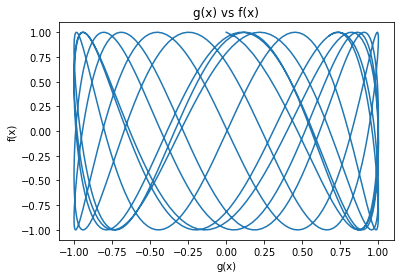

In [42]:
#2.1:
f = lambda x: np.sin(x**.9)
g = lambda x: np.cos(2*x + np.sqrt(x))

x_0 = np.linspace(0,50,1000)
plt.plot( f(x_0), g(x_0))
plt.title("g(x) vs f(x)")
plt.ylabel('g(x)')
plt.xlabel("f(x)")
plt.show()

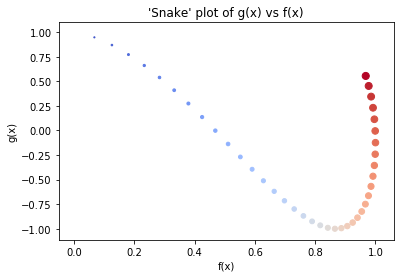

In [65]:
#2.2:
x = x_0[:40]
area = x*50/max(x)
plt.scatter(f(x), g(x), s=area, c=x, cmap='coolwarm')
plt.title("'Snake' plot of g(x) vs f(x)")
plt.xlabel('f(x)')
plt.ylabel('g(x)')
plt.show()

In [79]:
%%time
#2.3:
# NOTE: if trig_snake.mp4 doesn't play when opened in a new tab, please download it to view! Thanks!

#multiprocessing script: snakemovie.py
!./snakemovie.py
#can make into movie using !./snakemovies.sh snake
#or in one line here:
!ffmpeg  -framerate 30   -y -f image2  -pattern_type glob -i 'snake*.png' -preset slow -crf 18  -c:v libx264 -b:v 12000k  -pix_fmt yuv420p  trig_snake.mp4
        
#now remove all those snake pictures
!rm snake*.png

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

## 3. Random walk
In this problem you will program a random walk and explore its properties.
A two-dimensional random walk is the result of making random steps in both x- and y-directions. 

Tip: Start the program developement for very small parameters of number of steps and walks and check your results every step. Built you program out of small elements, one expression and one line at a time, each of which you check. This will save you time later  when you otherwise have a hard time finding bugs.

### 3.1 

Generate a data set that represents $n=10000$ random steps in the $(x,y)$ - plane. The random walk starts at $(x_0,y_0) = (0,0)$. Each of the following $n$ steps will advance by $\Delta x$ and $\Delta y$, each of which is either $+ 0.5$ or $-0.5$. Make a plot of the random walk by representing the position at each of the $n$ steps with a square marker in which the color represents the step number. 


In [330]:
#random walk func:
def rand_walk(n):
    x = [0]; y =[0] #start at (0,0)
    step = [-.5,.5]
    for j in range(1,n):
        x.append(random.choice(step)) #random step in x direction
        y.append(random.choice(step)) #random step in y direction
    return np.array(x),np.array(y)

#create random walk:
Nsteps = 10000
walk = (rand_walk(Nsteps))
x_walk = walk[0].cumsum() #summing to get x-coords
y_walk = walk[1].cumsum() #summing to get y-coords

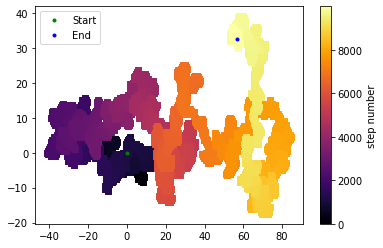

In [331]:
#plot:
fig = plt.scatter(x_walk, y_walk, marker='s', c=range(Nsteps), cmap='inferno')
plt.plot(x_walk[0],y_walk[0],'g.', label="Start")
plt.plot(x_walk[-1],y_walk[-1],'b.',label="End")
plt.legend()
plt.colorbar(fig, label='step number')

### 3.2 

Make $n_\mathrm{walk} = 1000$  walks of $n=10000$.  
* Each time save an array with the distance of each of the $n$ positions from the origin. 
* Plot a histogram  of the maximum and final distance in the same diagram, using the `alpha` option to make sure both histograms can be seen. 
* Plot the distance as a function of step number for every $100^\mathrm{th}$ walk.

In [338]:
#repeat n_walk n times
def repeat_walks(n,Nwalks):
    walks = []
    n = int(n)
    for j in range(Nwalks):
        walk = rand_walk(n) #take random walk
        x_walk = walk[0].cumsum() #x coords
        y_walk = walk[1].cumsum() #y coords
        walks.append(np.sqrt(x_walk**2+y_walk**2)) #distances
    return np.array(walks) 

#max and final distances
def walk_distances(walks):
    max_d = [] 
    final_d = []
    
    for n in walks:
        max_d.append(max(n))
        final_d.append(n[-1])
    
    max_d = np.array(max_d)
    final_d = np.array(final_d)
    return max_d,final_d

In [340]:
%%time
n = 10000
Nwalks = 1000
walks = repeat_walks(n,Nwalks)
max_d, final_d = walk_distances(walks)

CPU times: user 25.7 s, sys: 36.1 ms, total: 25.8 s
Wall time: 25.8 s


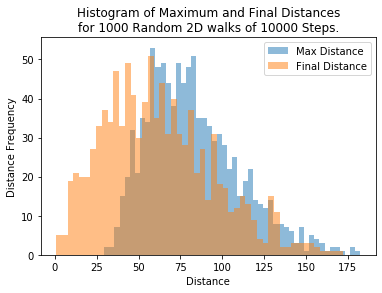

In [341]:
#plots
nbins = 50
plt.hist(max_d,alpha=0.5,bins=nbins,label="Max Distance")
plt.hist(final_d,alpha=0.5,bins=nbins,label="Final Distance")

plt.title("Histogram of Maximum and Final Distances\n"
     +"for %d Random 2D walks of %d Steps." %(Nwalks, n))
plt.ylabel("Distance Frequency")
plt.xlabel("Distance")
plt.legend()
plt.show()

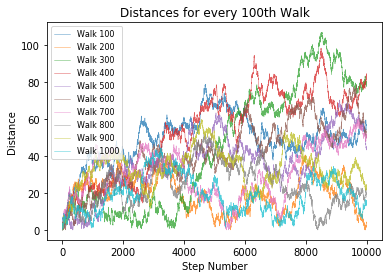

In [342]:
#distances for every 100th walk:
steps = np.arange(n)
i = np.arange(0,Nwalks,100)
d = walks[i-1]

#plot
for i in range(0,len(d)):
    plt.plot(steps,d[i],label="Walk {:d}00".format(i+1), alpha=.75, linewidth=.5)#, c=colour[i])
plt.legend(loc='best', fontsize=8)
plt.title('Distances for every 100th Walk')
plt.xlabel('Step Number')
plt.ylabel('Distance')
plt.show()

### 3.3
Explore the maximum distance the random walk gets away from the origin as a function of the number of steps taken. Make $n = 2^p$ steps for $p \in [4, 5, \dots ,13]$, and each time make $n_\mathrm{walk} = 1000$  walks to establish good statistics. For each of the 10 cases (one for each $p$) determine the distance $r_\mathrm{max-hist}$ at which the maximum of the histogram of the maximum distance of the $n_\mathrm{walk}$ walks for this case with $n$ steps is located. Then plot $r_\mathrm{max-hist}$ vs. $log_\mathrm{10} n$.

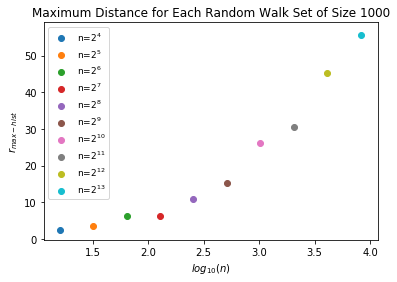

CPU times: user 43.8 s, sys: 1.58 s, total: 45.4 s
Wall time: 43.2 s


In [346]:
%%time

p = np.linspace(4,13, 13-3)
n = 2**p
Nwalks = 1000

for n,p in zip(n,p):
    walks = repeat_walks(n,Nwalks)
    max_d = walk_distances(walks)[0]
    d_hist = np.histogram(max_d,bins=nbins) #max distance histogram, numpy function bc not plotting
    
    freq_d = max(d_hist[0]) #most frequent max distance
    ind = list(d_hist[0]).index(freq_d) #index of the freq distance
    
    r_maxhist = d_hist[1][ind] # max of the histogram of the max distances.
    plt.scatter(np.log10(n),r_maxhist,label="n=$2^{%d}$"%p) 
    i+=1
plt.legend(fontsize=9)
plt.title('Maximum Distance for Each Random Walk Set of Size %d'%Nwalks)
plt.xlabel('$log_{10}(n)$')
plt.ylabel('$r_{max-hist}$')
plt.show()

## Problem 4

1. Create a python function `func1` that calculates 
$$f(x) = sin(x^3)\frac{x^3}{exp(-x)}$$ Make a plot for  $x\in[-2.5,1]$ using an x array representing 100 intervals.
2. Calculate the derivative $\frac{df}{dx}$ numerically and make a plot of the derivative.
3. Calculate the integral of $f(x)$ for $x\in[-2.5,1]$  using 
    * a library that uses a conventional discrete integration
    * a Monte-Carlo method
4. Solve the ODE $$\frac{dx}{dt} = f(x)$$ for the initial value $x_{01}=-1.465$, and a second time for $x_{02}=-1.463$ for $t\in[0,20]$. Make a plot of $x(t)$ for both initial value and explain briefly why the two trajectories is so different althoug the initial values are almost the same.

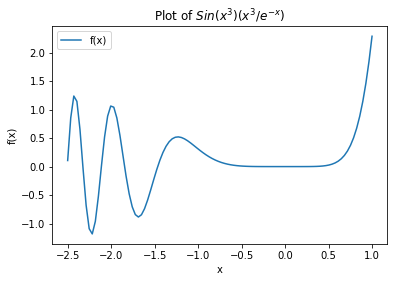

In [215]:
#1
f = lambda x: np.sin(x**3)*(x**3)/np.exp(-x)
x = np.linspace(-2.5,1,100)

plt.plot(x,f(x), label="f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Plot of $Sin(x^3)(x^3/e^{-x})$")
plt.legend()
plt.show()

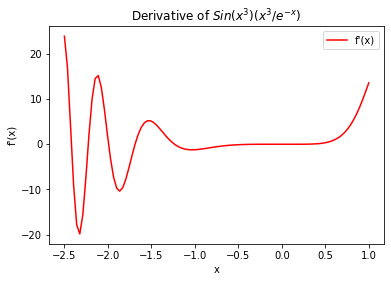

In [218]:
#2
def dfdx(f,x,h):
    return (f(x+h)-f(x))/h

dfdx = dfdx(f,x,0.001)  

plt.plot(x,dfdx,label="f'(x)", color='r')
plt.xlabel("x")
plt.ylabel("f'(x)")
plt.title("Derivative of $Sin(x^3)(x^3/e^{-x})$")
plt.legend()
plt.show()

In [229]:
#3
#library:
F_l = integrate.quad(f,x[0],x[-1])
print("Integral using quad method: %.3f"%round(sum(F_l),3))

#MC
def mcint(func,xrange,N):
    Dx = np.diff(xrange)[0] #xmax-xmin
    x = Dx*np.random.rand(N)+xrange[0]
    favg = func(x).mean()
    return favg*Dx

N = int(1e6)
F_mc = mcint(f,(-2.5,1),N)
print("Integral using Monte Carlo: %.3f" %round(F_mc,3))

Integral using quad method: 0.508
Integral using Monte Carlo: 0.508


4. Solve the ODE $$\frac{dx}{dt} = f(x)$$ for the initial value $x_{01}=-1.465$, and a second time for $x_{02}=-1.463$ for $t\in[0,20]$. Make a plot of $x(t)$ for both initial value and explain briefly why the two trajectories is so different althoug the initial values are almost the same.

In [261]:
#4
x=0
def dxdt(x,t):
    return np.sin(x**3)*(x**3)/np.exp(-x)

t_range = (0,20)
t = np.linspace(0,20)
x01 = -1.465
x02 = -1.463

# sol1 = integrate.solve_ivp(dxdt, t_range, [x01], t_eval=t)
# sol2 = integrate.solve_ivp(dxdt, t_range, [x02], t_eval=t)
sol1 = integrate.odeint(dxdt, x01, t)
sol2 = integrate.odeint(dxdt, x02, t)
#sol1.y.ravel(), sol1.t

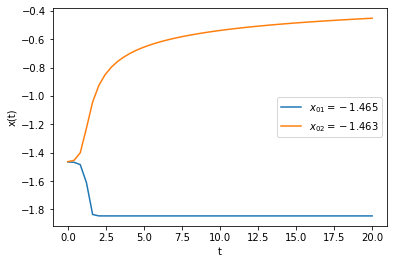

In [265]:
plt.plot(t, sol1, label='$x_{01} = -1.465$')
plt.plot(t, sol2, label='$x_{02} = -1.463$')
plt.legend()
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

The above plot shows very different values of x(t) for similar initial starting points, $x_{01}=-1.465$, and $x_{02}=-1.463$. This ODE may have this behaivour because it is a chaotic system, resulting in varying behaivour for initial conditions that are close to each other.

In [266]:
# plt.plot(sol1.t, sol1.y.ravel(), label='$x_{01} = -1.465$')
# plt.plot(sol2.t, sol2.y.ravel(), label='$x_{02} = -1.463$')
# plt.legend()